### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


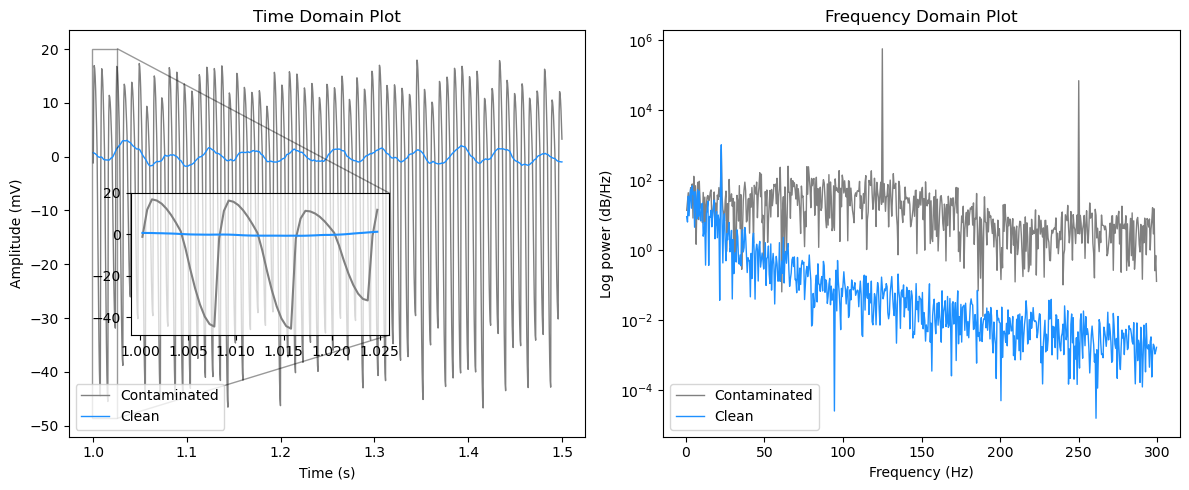

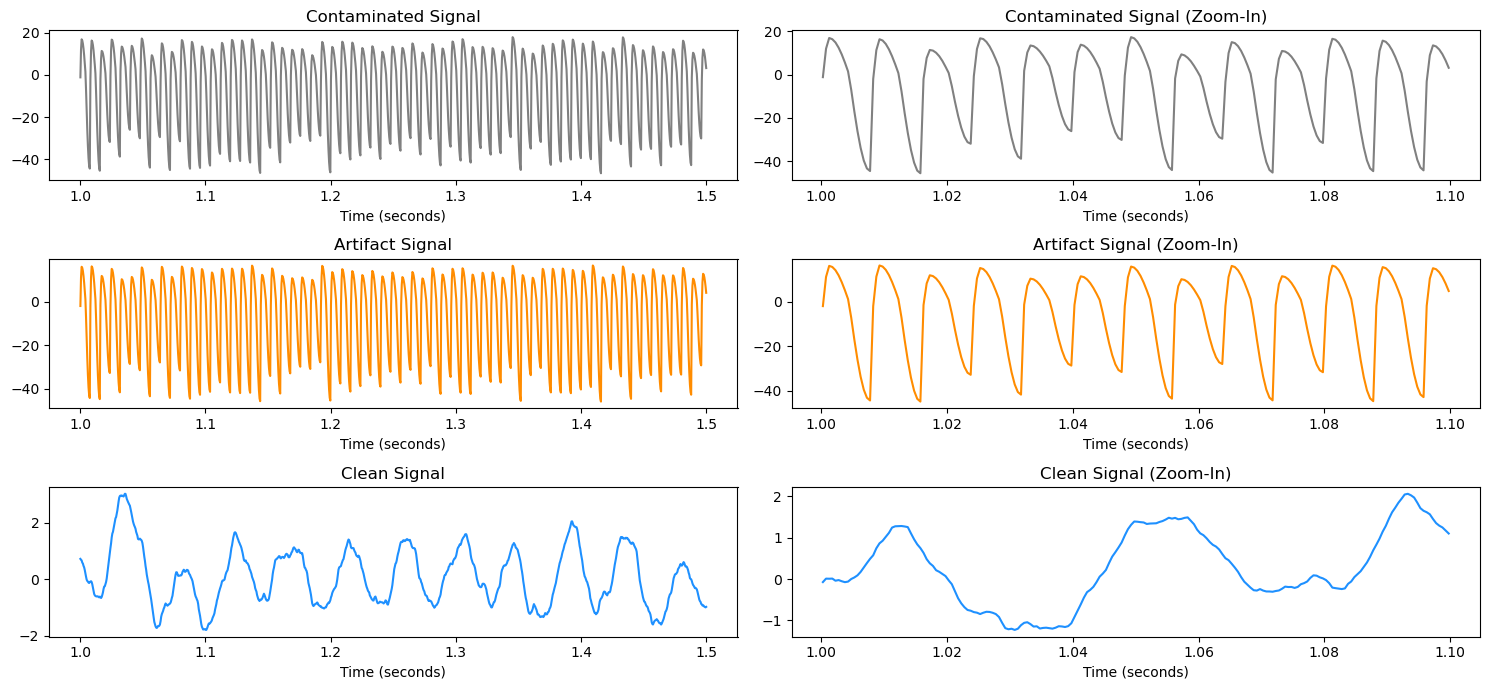

In [3]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [4]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [5]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000, 1)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000, 1)
-----------------------------


In [6]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)
        self.drop = nn.Dropout(0.25)
        self.gelu = nn.GELU()

    def forward(self, input_data): # x : B x T x 1
        x = self.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = self.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = self.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)

# 가중치 초기화 함수 정의
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier 초기화
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # 편향 초기화

# 모델의 가중치 초기화 적용
model.apply(init_weights)

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)

In [7]:
# 손실 함수 정의 

class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

        # 학습 가능한 가중치 파라미터
        self.signal_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.fft_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, y_pred, y, y_pred_fft, y_fft):
        signal_loss = self.mse_loss(y_pred, y)
        fft_loss = self.mse_loss(y_pred_fft, y_fft)

        # 가중치 적용
        total_loss = self.alpha * (signal_loss * self.signal_weight) + \
                     (1 - self.alpha) * (fft_loss * self.fft_weight)

        return total_loss


In [8]:
# 손실 함수와 옵티마이저 정의
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 200

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T x 1
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)

        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 5/200, Loss: 0.00021287456911522895
Epoch 10/200, Loss: 0.00019085600797552615
Epoch 15/200, Loss: 0.00018243958766106516
Epoch 20/200, Loss: 0.0001766165514709428
Epoch 25/200, Loss: 0.00017342306091450155
Epoch 30/200, Loss: 0.00017104046128224581
Epoch 35/200, Loss: 0.00016793597023934126
Epoch 40/200, Loss: 0.00016517029143869877
Epoch 45/200, Loss: 0.0001635075022932142
Epoch 50/200, Loss: 0.00016182004765141755
Epoch 55/200, Loss: 0.00015994091518223286
Epoch 60/200, Loss: 0.00015849483315832913
Epoch 65/200, Loss: 0.00015703101234976202
Epoch 70/200, Loss: 0.00015569970128126442
Epoch 75/200, Loss: 0.00015440036077052355
Epoch 80/200, Loss: 0.00015368602180387825
Epoch 85/200, Loss: 0.00015220647037494928
Epoch 90/200, Loss: 0.00015121078467927873
Epoch 95/200, Loss: 0.00015025005268398672
Epoch 100/200, Loss: 0.0001495408359915018
Epoch 105/200, Loss: 0.00014888172154314816
Epoch 110/200, Loss: 0.00014821944932918996
Epoch 115/200, Loss: 0.00014768686378374696
Epoch 120/2

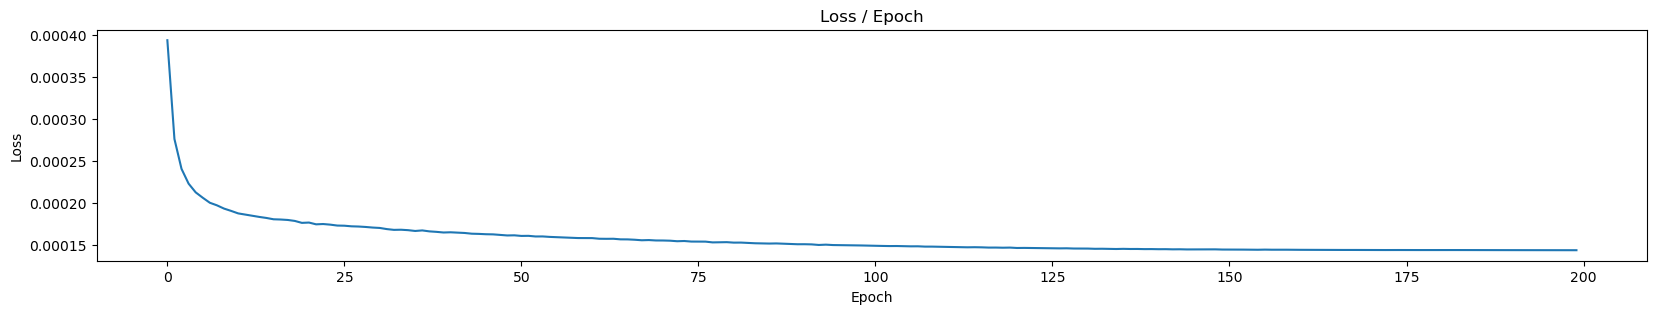

Minimal Loss: 0.00014410620497073978 [192]



In [9]:
# Train Loss Plot
Loss_Plot(loss_list)

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)
    
        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_fft.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_fft.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}')           

Validation Loss: 0.0001440263877157122


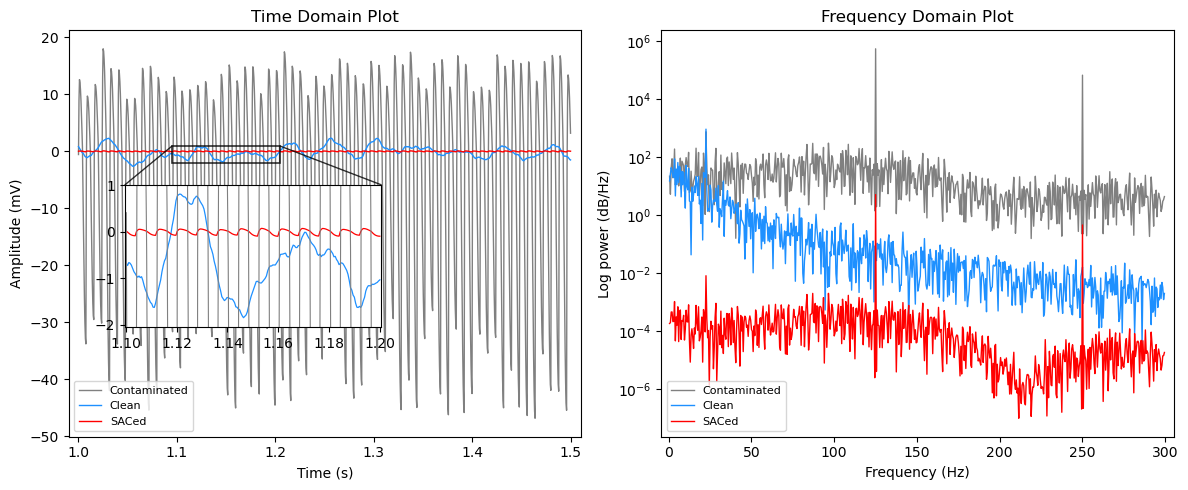

<Time Domain Error>
Mean Absolute Error: 0.8146
Mean Squared Error: 0.9965
<Frequency Domain Error>
Mean Absolute Error: 1.9946
Mean Squared Error: 2060.3794


In [11]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

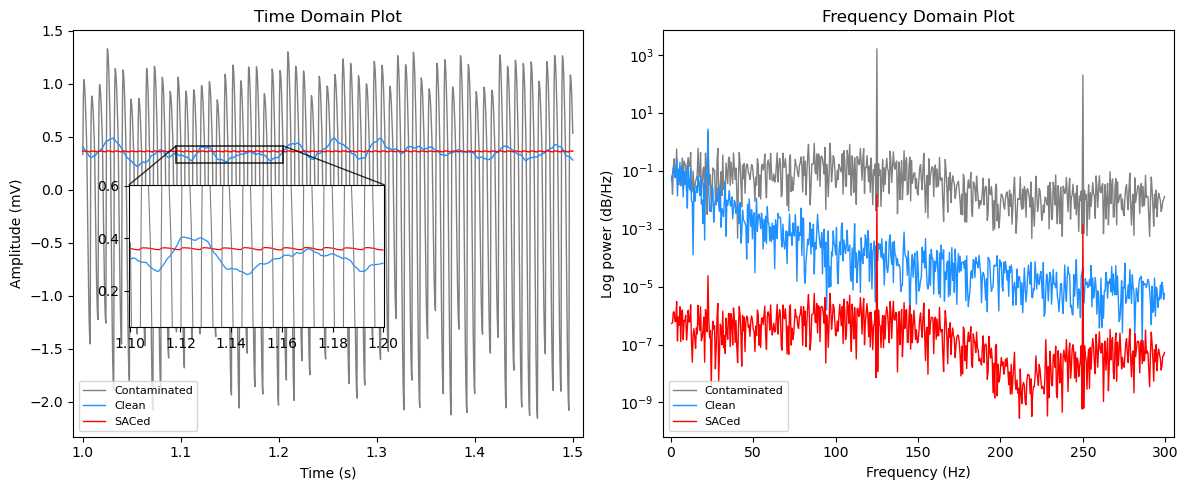

<Time Domain Error>
Mean Absolute Error: 0.0438
Mean Squared Error: 0.0029
<Frequency Domain Error>
Mean Absolute Error: 0.0058
Mean Squared Error: 0.0172


In [12]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)